# Photometry of an open cluster

This juypter notebook consist of the scripts necessary to calculate the color-magnitude diagram of an open cluster. The individual scripts here assume perfectly calibrated and reduced (hence bias-, flat- and dark-frame corrected) observations. In case the calibrations were not done completely, some scripts (especially the star finding) may not work properly.

#### Steps of analysis:

- Star detection

- Photometry:
    - Aperture size calculation
    - Measuring counts

- Calibrating photometry zero-point

### Disclaimer / important information
This pipeline perform the very basic photometry all objects in the figure. Whereas this is perfectly enough for this exercise and it shows the backbone principle of the analysis, this is in no way reflects the state of the art stage of photometry: the procedure itself can be improved in several ways. Feel free to experiment with different setups and methods in this notebook; this initial version is just an example of how the photometry can be performed.

### Dependencies

This notebook assumes that it runs under python 3.10; for the complete list of dependecies, consult the environment file at https://github.com/Csogeza/FoPra85. This is important, since some sub-routines don't run under earlier versions of python. If your python version does not match the requested done, I recommend you to set up a new environment with anaconda (instead of updating the old one; do not do that, there is always a risk of irreversible upgraded corruption with python) or use the Google Colab version of this notebook.

### As a first step, the relevant python packages have to be imported.

In [1]:
%pylab inline
from astropy.io import fits
import pandas as pd
import os

from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks
from photutils import CircularAperture
from photutils.aperture import ApertureStats
from photutils import background
from photutils import aperture_photometry
from astropy.stats import SigmaClip

from astropy.nddata import Cutout2D

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Load the file(s) that you will be working on.

In [39]:
# Give the path to the files
path_to_obs = './Data/Data/Science_combined/'

# The codes below assume that they are in the order of B G R, but this can be easily modified
observation_files = [fts for fts in os.listdir(path_to_obs) if fts.startswith('combined')]
print(observation_files)

# Pick one of the three to run the test photometry on
test_data = fits.open(path_to_obs + observation_files[2])

# Get the pixel map for this image; if everything goes right, we will not need anything else from the header
test_pixel_values = test_data[0].data

['combined_M57_Blue.fits', 'combined_M57_Green.fits', 'combined_M57_Red.fits']


Display the image in a suitable intensity range; this range can be adjusted with the vmin and vmax parameters, in case the image is too bright/too dark.

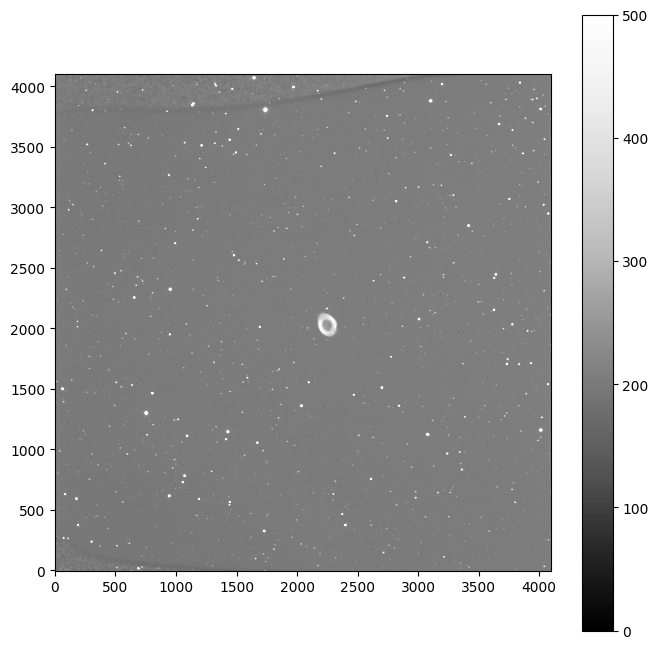

In [40]:
plt.figure(figsize = (8,8))
plt.imshow(test_pixel_values, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 500)
plt.colorbar()

## Star identification

There are a lot of stars on these figures, and ideally, we would want to calculate a magnitude for each. Doing so and identifying each one-by-one would require a very long amount of time; hence we try to identify them automatically. This is done through astropy's find_peaks method. The basic principle is, that we know how much the background fluctuates; a lot less than the effect a star causes. Hence if we detect a peak on the figure, that is way more significant, than the actual fluctuations (say, for example, 10 times greater, than the standard deviation of the background pixel counts), then we can safely flag that as a star (assuming the figure has been corrected to cosmic ray hits and/or overcharged pixels).

This step is done in the cell below. After the background level estimation, the first script finds all peaks that exceed the standard deviation 15 times, while scanning with steps of 10 pixel at a time. Whereas this finds all peaks on the figure, we discard the ones at the edges (due to these being usually more prone to calibration errors, but excluding these makes the analysis also simpler).

These numbers were chosen empirically; feel free to change them, if you wish to experiment.

In [182]:
# Estimate background level through sigma clipping
from astropy.stats import SigmaClip
sigma_clip = SigmaClip(sigma=3.) # Everything above 3 sigma will be clipped
bkg_estimator = background.MedianBackground()
# Estimate background level by looking at 50x50 cutouts
bkg = background.Background2D(test_pixel_values, (50, 50), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

median_bkg = bkg.background_median
# Find the stars/peaks on the image

# There are two tuneable parameters here

bkg_mult = 25 # This will set the limit for the peaks; anything above background fluctuations
              # times this number will be included. Basically this sets the brightness of the
              # stars that will be included; the lower it is, the fainter star will also be in the sample.
        
box_size = 30 # This sets how close the peaks can be next to one another

peak_table = find_peaks(test_pixel_values, bkg.background_rms_median * bkg_mult, box_size = box_size)

# Remove everything that is on the edges of the figure. This condition can be further customized if additional areas
# has have to be excluded.

edge_lim = 50 # This sets how far off the image edges we start to include stars
cond1 = (peak_table['x_peak'] > edge_lim) & (peak_table['x_peak'] < test_pixel_values.shape[0] - edge_lim) & \
        (peak_table['y_peak'] > edge_lim) & (peak_table['y_peak'] < test_pixel_values.shape[1] - edge_lim)

# Remove peak detections that are due to hot pixels; check if the pixel median close to the peak exceeds 2 * background level
cond2 = np.zeros(cond1.shape)
for i in range (cond2.shape[0]):
    close_median = np.median(test_pixel_values.T[peak_table['x_peak'][i] - 1 : peak_table['x_peak'][i] + 2,
                                                 peak_table['y_peak'][i] - 1 : peak_table['y_peak'][i] + 2])
    if close_median > 1.5 * median_bkg:
        cond2[i] = 1   # If exceeds, then it is a true detection
        
cond2 = cond2.astype(bool)

cond_final = np.logical_and(cond1,cond2) # Combine the two conditions

peak_table = peak_table[cond_final]

The figure below shows the stars that were found, along with their ID-s, that will be used to flag them.

Keep in mind that the algorithm does not know what it looks at! This means, that if there is a nebula or something else on the figure, the script will also flag parts of it as stars. Of course, if we wanted to analyse the surroundings of that nebula, then some additional considerations should be made, but for this example, we just don't care about it.

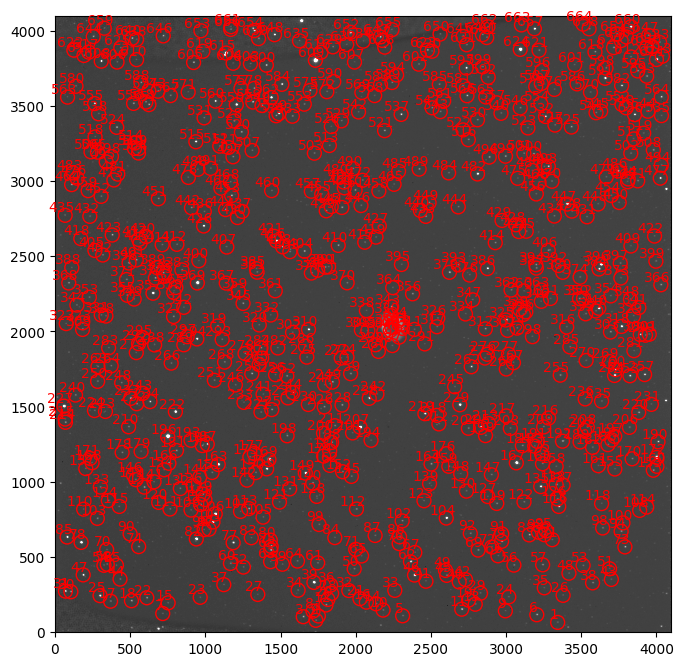

In [183]:
plt.figure(figsize = (8,8))
plt.imshow(test_pixel_values, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 1000)

plt.scatter(peak_table['x_peak'], peak_table['y_peak'], s=100, edgecolors='r', facecolors='none')
for i in range (len(peak_table)):
    plt.text(peak_table['x_peak'][i]-25, peak_table['y_peak'][i]+25, str(i+1),
             color = 'red', horizontalalignment = 'center')

### If things get confusing and crowded, we can zoom in a bit

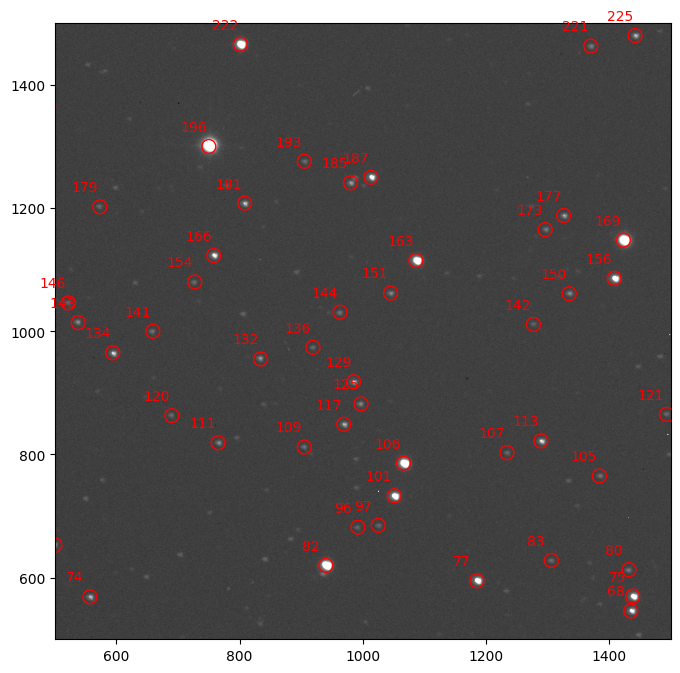

In [184]:
plt.figure(figsize = (8,8))
plt.imshow(test_pixel_values, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 1000)
plt.scatter(peak_table['x_peak'], peak_table['y_peak'], s=100, edgecolors='r', facecolors='none')

x_lims = [500, 1500]
y_lims = [500, 1500]

plt.xlim(x_lims[0],x_lims[1])
plt.ylim(y_lims[0],y_lims[1])
for i in range (len(peak_table)):
    if peak_table['x_peak'][i] > x_lims[0] and peak_table['x_peak'][i] < x_lims[1] and \
        peak_table['y_peak'][i] > y_lims[0] and peak_table['y_peak'][i] < y_lims[1]:
        plt.text(peak_table['x_peak'][i]-25, peak_table['y_peak'][i]+25, str(i+1),
                 color = 'red', horizontalalignment = 'center')

### From these images we can tell how good is our star identification method. There may be a few stars that are not identified, but then those would also be less reliable.

Changing the parameters for the peak finder method can help in identifying the stars that were not marked before, but bear in mind that this also increases the chance for hot pixels and such to be included.

## Let's try to do the photometry for a single star on the frame!

For this, we first need to pick a star we like from the image, and cut it out so that only its immediate surroundings remain on  the image.

In [185]:
# Define a function to cut out the stars one by one

def get_cutout(ind, pixel_data):
    
    position = (peak_table['x_peak'][ind], peak_table['y_peak'][ind])  # Where the cutout should be centered; where the star is
    size = (100, 100)     # The size of the cutout in pixels
    star1 = Cutout2D(pixel_data, position, size) # The cutout is made here
    
    return star1

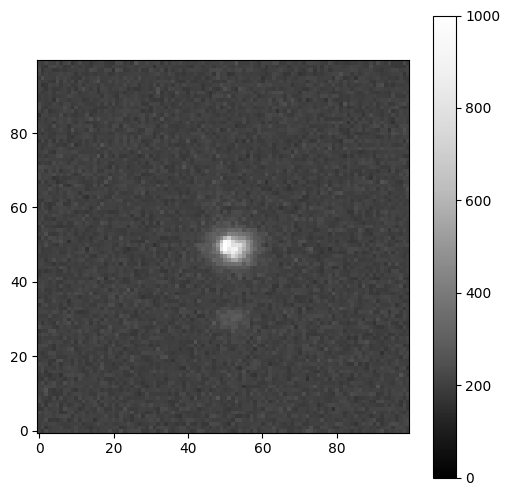

In [186]:
i = 87

star1 = get_cutout(i, test_pixel_values)

plt.figure(figsize = (6,6))
plt.imshow(star1.data, origin='lower', cmap = 'Greys_r', vmin = 0, vmax = 1000)
plt.colorbar()

Imagine this figure as a bottom of a bucket; each pixel defines a position while the color tells us how many photons were dropped onto that position. A 3d plot grasps this aspect better:

Text(0.5, 0, 'Pixel count')

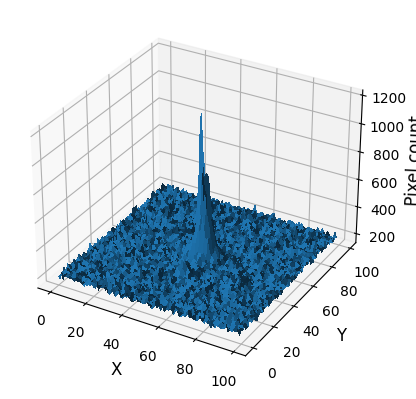

In [187]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xx = np.linspace(0, star1.data.shape[0] - 1, star1.data.shape[0])
X, Y = np.meshgrid(xx, xx)
ax.plot_surface(X, Y, star1.data, linewidth=1, antialiased=False)

ax.set_xlabel('X', fontsize = 12)
ax.set_ylabel('Y', fontsize = 12)
ax.set_zlabel('Pixel count', fontsize = 12)

#### This is the 3D representation of the image above; the x and y axes show the pixel coordinates, while the z axis show the CCD counts.
The background fluctuation can clearly be seen, whereas the peak in the middle shows where the star is

What we essentially want to do, is to caluclate how many counts were acquired in the region where the star is, then compare it with other stars. However, this is a tricky step, since we need to find a region on the cutout, which contains _only_ the star we want to estimate the brightness for. Ideally, we want to limit this region so that the edge of it would be on the "foot of the pixel mountain", i.e. still in the region that is dominated by the flux from the star. Having a larger one is not a problem either; unless there are other stars in the cutout.

Given that we are working with clusters, stars can get very close to each other; in that case, a smaller aperture has to be used for the calculation. On the other hand, brighter stars take up more space on the figure, hence in their case, a wider aperture has to chosen. To balance these two effects, the aperture radius has to be chosen dynamically, which can be done easily based on the full width at half maximum (FWHM) of the intensity profile.

#### One example on photometry with different aperture sizes can be seen below

Here the aperture size is increased at each step and the photometry is carried out with each. The basic idea is that the number of counts (after subtracting teh background) are summed simply within the aperture. 

On the figure below you can see that the number off counts levels off at some point when compared to the aperture size, meaning that there is a charachteristic smallest radius which already contains all the flux from the star.

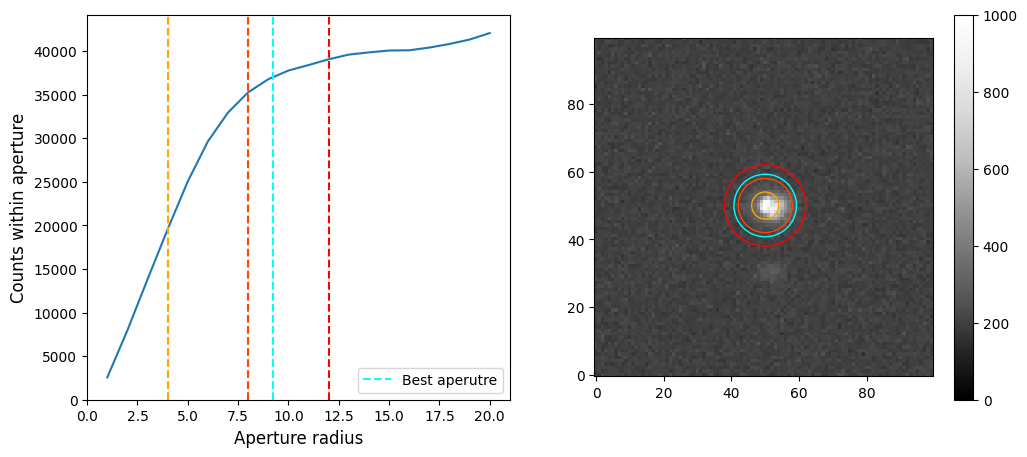

In [190]:
# But what is the idea behind the full width at half maximum?

# Let's plot how the acquired number of counts changes if we pick larger and larger apertures!

f = plt.figure(figsize = (12,5))

apss = []

pos = (int(star1.data.shape[0]/2), int(star1.data.shape[0]/2))

bkg = background.Background2D(star1.data, (30, 30), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

for i in range (20):
    # Set up a circular aperture at a given position with a given radius
    obj_aperture = CircularAperture(pos, r=i+1)
    # Carry out the photometry; the resulting table will contain the sum of the counts
    # Don't forget to subtract the background; if it is non-zero, it would bias the photometry
    obj_table = aperture_photometry(star1.data - bkg.background_median, obj_aperture) 
    apss.append(obj_table['aperture_sum'])    
    
best = aperstats.fwhm.value * 1.75
# The best value is usually the one that is fixed to the full width at half maximum. 

ax = f.add_subplot(1,2,1)
plt.plot(np.arange(1,21,1), apss)

plt.axvline(4, ls = '--', color = 'orange')
plt.axvline(8, ls = '--', color = 'orangered')
plt.axvline(12, ls = '--', color = 'red')
plt.axvline(best, ls = '--', color = 'aqua', label = 'Best aperutre')

plt.legend()

plt.xlim(0, 21)
plt.ylim(0, 1.05 * max(apss))

plt.xlabel('Aperture radius', fontsize = 12)
plt.ylabel('Counts within aperture', fontsize = 12)

ax = f.add_subplot(1,2,2)
plt.imshow(star1.data, origin='lower', cmap = 'Greys_r', vmin = 0, vmax = 1000)
plt.colorbar()

circle1 = plt.Circle(pos, 4, color = 'None', ec = 'orange')
ax.add_patch(circle1)
circle2 = plt.Circle(pos, 8, color = 'None', ec = 'orangered')
ax.add_patch(circle2)
circle3 = plt.Circle(pos, 12, color = 'None', ec = 'red')
ax.add_patch(circle3)
circle4 = plt.Circle(pos, best, color = 'None', ec = 'aqua')
ax.add_patch(circle4)

### Essentially this is done below in a slightly more complicated way
The complication arises when there are other stars in the field. In this case, the aperture has to be limited, otherwise at some point it will gather flux from the other star, which will bias the measurements, and make us choose the wrong aperture size. To process looks as follows:

- First check for other stars in the cutout. If there are none, the case is simple.

- If there are, find the closest, and derive an upper limit for the aperture size based on the relative brightness of that object to our target star.

- Carry out the above aperutre size measurement keeping in mind the upper limit.

In [192]:
def get_aperture_size(star1):
    
    # First, get a list of stars on the cutout, and tell how far they are from the center
    bkg = background.Background2D(star1.data, (30, 30), filter_size=(3, 3),
                                  sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        
    
    star_tab = find_peaks(star1.data, bkg.background_rms_median * 10, box_size = 8)
    
    size = (100, 100)
    distances_from_mid = np.sqrt(np.square(star_tab['x_peak'] - size[0]/2) \
                                 + np.square(star_tab['y_peak'] - size[1]/2))

    star_tab = star_tab[distances_from_mid > 3]   # Limit this for further away targets; due to some errors the same star can
                                                  # get flagged twice
    distances_from_mid = distances_from_mid[distances_from_mid > 3]

    # Unless there is only one star on the cutout, try to find the closest neightbour
    if len(distances_from_mid) > 1:
        mindist = np.min(distances_from_mid)

        neighbour_ind = list(distances_from_mid).index(mindist)

        # Get the peak intensity of the neighbour star and the one we try to estimate the brightness for
        neighbour_max_count = star1.data.T[star_tab['x_peak'][neighbour_ind], star_tab['y_peak'][neighbour_ind]]
        star_max_count = star1.data[int(size[0]/2), int(size[1]/2)]

        # Estimate the weighted midpoint between the two stars: this is the limiting point, which sets how far our aperture can
        # extend. Furhter away it is likely, that the majority of the flux comes from the neighbour star, which could contaminate
        # our measurement.
        mid_p = star_max_count / (neighbour_max_count + star_max_count) * (mindist - 4) + 2
        # Here, we apply the scaling with the peak fluxes, so that the midpoint will be closer to our star, in case it is fainter
        # than the neighbour (and it takes up less area). We set the minimal midpoint distance to 2; this area still likely belongs
        # to the star we want to observe, if it was found by the peak finder algorithm.

    else:
        # If there are no neighbour stars, then we can set this maximal distance manually. It is unlikely that a star covers
        # more than 11 pixels; in such case, it is likely that it is saturated already.
        mid_p = 21

    # The position of the measured star on the cutout; it should always be in the center.
    pos = (size[0]/2, size[1]/2)

    apss = []

    # To measure the best size for the aperture, one has to calculate the FWHM. This can be done through analytic fitting of a 
    # profile to the intensity distribution, or by an astropy routine. The second however requires the photometry to be carried out
    # first; hence, we carry out the aperture photometry chosing different sizes, then evaluate the results. Once done, we simply 
    # choose the best one, i.e. the smallest, that already contains most of the star, since that is the least biased.

    upper_lim = 20
    if mid_p < upper_lim:
        upper_lim = mid_p
        # Set the limit for the iterative caluclation. We don't want to go beyond the midpoint as explained above. 

    for i in range (int(upper_lim)):
        # Set up a circular aperture at a given position with a given radius
        obj_aperture = CircularAperture(pos, r=i+1)
        # Carry out the photometry; the resulting table will contain the sum of the counts
        # Don't forget to subtract the background; if it is non-zero, it would bias the photometry
        obj_table = aperture_photometry(star1.data - bkg.background_median, obj_aperture) 
        if i > 0 and obj_table['aperture_sum'] < apss[i-1]:
            break
        apss.append(obj_table['aperture_sum'])

    aperstats = ApertureStats(star1.data, obj_aperture) 
    # Calculate the FWHM based on the largest possible aperture
    best = aperstats.fwhm.value * 1.75
    
    return best, aperstats

### The figure below shows the found best aperture; the aperture is also recentered to the weighted mean position based on the counts to reduce error

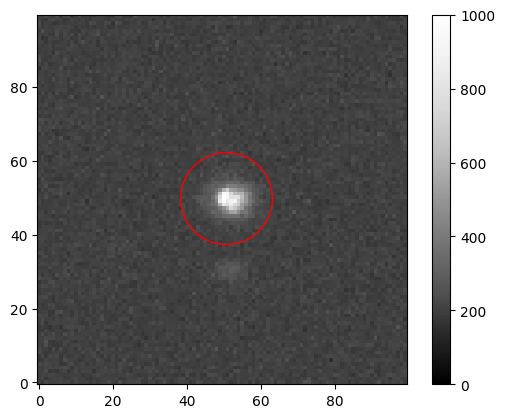

In [193]:
best, aperstats =  get_aperture_size(star1)

fig, ax = plt.subplots()
plt.imshow(star1.data, origin='lower', cmap = 'Greys_r', vmin = 0, vmax = 1000)

circle1 = plt.Circle((aperstats.centroid[0], aperstats.centroid[1]), best, color = 'None', ec = 'red')

ax.add_patch(circle1)
plt.colorbar()

### Once the aperture size and its center are set, we can proceed to the actual photometry,  which can be done in a single row.

It is important to bear in mind that the background has to be subtracted here too.

In [194]:
bkg = background.Background2D(star1.data, (30, 30), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

obj_aperture = CircularAperture(aperstats.centroid, r=best)
obj_table = aperture_photometry(star1.data - bkg.background_median, obj_aperture)
obj_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,50.69925009674262,49.748378089244255,39374.43919650569


### Let's do this procedure for all the stars

The script below runs the above task to all the stars, and in turn, we get a list of counts for each of the stars in the figure

In [202]:
import warnings
warnings.filterwarnings("ignore")

# The DataFrame with the final results. This will be filled iteratively
frame_count_table = pd.DataFrame()

for i in range (len(peak_table)):
    star1 = get_cutout(i, test_pixel_values)
    try:
        best, aperstats =  get_aperture_size(star1)
    except TypeError:    # If there is a nebula on the figure, it will cause additional problems
        continue
    
    bkg = background.Background2D(star1.data, (30, 30), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    
    obj_aperture = CircularAperture(aperstats.centroid, r=best)
    obj_table = aperture_photometry(star1.data - bkg.background_median, obj_aperture)
    
    temp = pd.Series([i+1, peak_table['x_peak'][i], peak_table['y_peak'][i], obj_table['aperture_sum'][0]],
                     ['Star_ID', 'X_c', 'Y_c', 'Count'])
    
    frame_count_table = frame_count_table.append(temp, ignore_index = True)

Now, we have the intensity counts for all the stars in the frame. What we need to do now, is to convert this to magnitudes, which we can interpret. For this, we have to find a star in the figure, for which we know the exact brightness value. 

This step can be done through multiple webpages. The one we recommend using is the aladin website: https://aladin.u-strasbg.fr/AladinLite/ Here, one can compare the observed frame to various catalogues, then can identify stars and check their magnitudes.

Below we included some dummy data to show how this can be done. First, one has to pick an object ID, for which the magnitude is known, then note down its magnitude. This can be done for multiple objects; the more included, the more precise will the final magnitudes be. Just make sure that the IDs and magnitudes don't get mixed up.

For a qualitative analysis, it is enough to set the magnitudes of only one star, and it can be set to any arbitrary value. Whereas this obviously leads to an offset along both the magnitude and color axes on the CMD, it will not affect their shapes.

In [204]:
ID_ref = [41]

ind_ref = np.array([list(frame_count_table['Star_ID']).index(ID_ref[i]) for i in range (len(ID_ref))])

mag_ref_list = np.array([9.1])

mags = np.zeros((len(frame_count_table)))

for i in range (len(frame_count_table)):   # The implementation of the flux/counts --> magnitude formula
    mags[i] = np.average([-2.5 * np.log10(frame_count_table['Count'][i]/frame_count_table['Count'][ind_ref[j]]) \
                          + mag_ref_list[j] for j in range (len(ind_ref))])

frame_count_table['Mag'] = mags 

### The results are then summarized in a final table of magnitudes

In [205]:
frame_count_table

,Star_ID,X_c,Y_c,Count,Mag
0,1.0,3343.0,65.0,10974.544438,8.701734
1,2.0,1735.0,79.0,13036.130307,8.514828
2,3.0,1651.0,103.0,38544.514702,7.337794
3,4.0,1752.0,108.0,11038.652920,8.695410
4,5.0,2312.0,109.0,13678.576074,8.462598
...,...,...,...,...,...
658,660.0,3830.0,4025.0,159807.734655,5.793705
659,661.0,1170.0,4026.0,7727.590087,9.082590
660,662.0,2879.0,4026.0,17443.978654,8.198586
661,663.0,3102.0,4038.0,10488.666387,8.750899


### This was the basic outline of the procedure. To obtain a CMD, one has to carry this out for both the B and the V band images too. This is done by the script below; only the filenames have to be modified to get the correct result.

In [207]:
# Assume that the frames are well aligned; i.e. there is no need for rotational corrections and such, so we can use the same
# peak_tab as before

# B band observation filt_ind = 0

Blue_o_arr = fits.open(path_to_obs + observation_files[0])[0].data.astype(float)
Green_o_arr = fits.open(path_to_obs + observation_files[1])[0].data.astype(float)
Red_o_arr = fits.open(path_to_obs + observation_files[2])[0].data.astype(float)


# List of frames in different bands; they should be in the order of B G R for this script to work properly
corr_arr_s = [Blue_o_arr, Green_o_arr, Red_o_arr]
bandlist = ['B', 'G', 'R']

final_count_table = pd.DataFrame()

for i in range (len(peak_table)):   # Goes through all the detected stars; use the same peak table as before
    
    count_vls = []
    added_bands = []
    
    try:
        for j in range (len(corr_arr_s)):  # Goes through the different bands

            star1 = get_cutout(i, corr_arr_s[j])
            best, aperstats =  get_aperture_size(star1)
            
            bkg = background.Background2D(star1.data, (30, 30), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

            obj_aperture = CircularAperture(aperstats.centroid, r=best)
            obj_table = aperture_photometry(star1.data - bkg.background_median, obj_aperture)

            count_vls.append(obj_table['aperture_sum'][0])
            added_bands.append(bandlist[j] + '_count')
            
    except TypeError:
        continue     # It sometimes happens that there are no intensity peaks in the cutouts taken in bands that are different
                     # from the one we used to calculate the peak_tab. This can happen when the original peak was due to an
                     # artifact; hot pixels and such. Better leave these out.
    
    row = [i+1, peak_table['x_peak'][i], peak_table['y_peak'][i]]
    row.extend(count_vls)
    
    colnames = ['Star_ID', 'X_c', 'Y_c']
    colnames.extend(added_bands)
    
    temp = pd.Series(row, colnames)
    
    final_count_table = final_count_table.append(temp, ignore_index = True)

In [208]:
final_count_table

,Star_ID,X_c,Y_c,B_count,G_count,R_count
0,1.0,3343.0,65.0,84.321605,875.610073,10974.544438
1,2.0,1735.0,79.0,39.684539,2559.031367,13036.130307
2,3.0,1651.0,103.0,476.512924,1744.890357,38544.514702
3,4.0,1752.0,108.0,598.442128,452.827207,11038.652920
4,5.0,2312.0,109.0,617.444186,2033.963893,13678.576074
...,...,...,...,...,...,...
657,660.0,3830.0,4025.0,671.048094,6411.343915,159807.734655
658,661.0,1170.0,4026.0,109.704479,745.105599,7727.590087
659,662.0,2879.0,4026.0,1358.991660,450.539379,17443.978654
660,663.0,3102.0,4038.0,151.966011,486.992019,10488.666387


### This table contains the number of acquired counts for each of the stars on the three frames in the different filtes.

Turning the counts to magnitudes requires the same steps as above. Find a star, set its magnitudes (in both filters now), then simply convert the counts to magnitudes.

In [209]:
ID_ref = [41]

ind_ref = np.array([list(final_count_table['Star_ID']).index(ID_ref[i]) for i in range (len(ID_ref))])

mag_ref_B = np.array([9.140])
mag_ref_V = np.array([9.140])
mag_ref_R = np.array([9.000])

B_mags = np.zeros((len(final_count_table)))
G_mags = np.zeros((len(final_count_table)))
R_mags = np.zeros((len(final_count_table)))

for i in range (len(final_count_table)):
    B_mags[i] = np.average([-2.5 * np.log10(final_count_table['B_count'][i]/final_count_table['B_count'][ind_ref[j]]) \
                            + mag_ref_B[j] for j in range (len(ind_ref))])
    G_mags[i] = np.average([-2.5 * np.log10(final_count_table['G_count'][i]/final_count_table['G_count'][ind_ref[j]]) \
                            + mag_ref_V[j] for j in range (len(ind_ref))])
    R_mags[i] = np.average([-2.5 * np.log10(final_count_table['R_count'][i]/final_count_table['R_count'][ind_ref[j]]) \
                            + mag_ref_R[j] for j in range (len(ind_ref))])

final_count_table['B'] = B_mags 
final_count_table['G'] = G_mags 
final_count_table['R'] = R_mags 

### The final dataframe, that includes the magnitude values as well

In [211]:
final_count_table
#final_count_table.to_csv('./test_data.csv')

,Star_ID,X_c,Y_c,B_count,G_count,R_count,B,G,R
0,1.0,3343.0,65.0,84.321605,875.610073,10974.544438,10.813063,8.574854,8.601734
1,2.0,1735.0,79.0,39.684539,2559.031367,13036.130307,11.631356,7.410442,8.414828
2,3.0,1651.0,103.0,476.512924,1744.890357,38544.514702,8.932723,7.826211,7.237794
3,4.0,1752.0,108.0,598.442128,452.827207,11038.652920,8.685354,9.290800,8.595410
4,5.0,2312.0,109.0,617.444186,2033.963893,13678.576074,8.651415,7.659773,8.362598
...,...,...,...,...,...,...,...,...,...
657,660.0,3830.0,4025.0,671.048094,6411.343915,159807.734655,8.561026,6.413258,5.693705
658,661.0,1170.0,4026.0,109.704479,745.105599,7727.590087,10.527349,8.750086,8.982590
659,662.0,2879.0,4026.0,1358.991660,450.539379,17443.978654,7.794868,9.296299,8.098586
660,663.0,3102.0,4038.0,151.966011,486.992019,10488.666387,10.173544,9.211826,8.650899


### We can then export this DataFrame using final_count_table.to_csv() and plot the CMD based on it

# ------------------------------------------------------------------------------------------------------------

# The below scripts can only work if one is working with open cluster data; for a random field, they will not be meaningful

Below you will find an example script that can be used for CMD plotting

In [22]:
def plot_CMD(band1, band2, df, vmi = None, vma = None):   # band1 and band2 are the to-be-plotted columns, df is the DataFrame
    if vmi == None:
        plt.scatter(df[band1] - df[band2], df[band2], s = 10, c = df[band1] - df[band2], cmap = 'coolwarm')
    else:
        plt.scatter(df[band1] - df[band2], df[band2], s = 10, c = df[band1] - df[band2], cmap = 'coolwarm',
                    vmin = vmi, vmax = vma)
    plt.gca().invert_yaxis()

    plt.xlabel(band1 + '$-$' + band2, fontsize = 12)
    plt.ylabel(band2, fontsize = 12)

Now we only need to plot the CMDs; the colours go on the x axis, while the magnitudes go on the y axis.

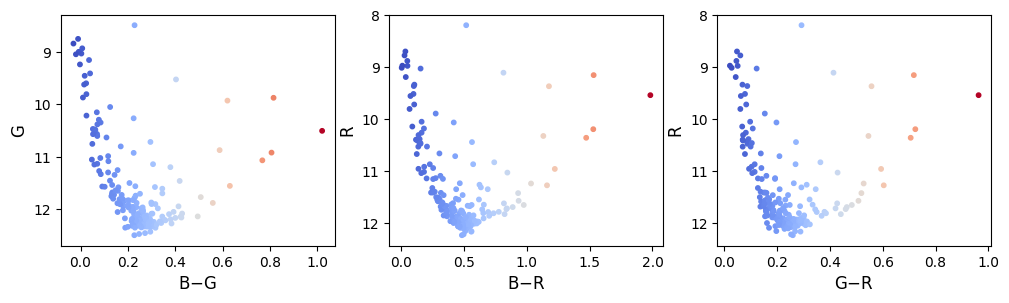

In [23]:
f = plt.figure(figsize = (12,3))

# Assuming df contains the magnitude table

ax = f.add_subplot(1,3,1)
plot_CMD('B', 'G', df)

ax = f.add_subplot(1,3,2)
plot_CMD('B', 'R', df)

ax = f.add_subplot(1,3,3)
plot_CMD('G', 'R', df)

The main sequence is drawn out pretty nicely; however, there are a lot of outlier stars. Some of these are outliers due to not being part of the open cluster; given that we have applied the photometry on all the stars in the frame, we potentially include objects outside the cluster. To remove these, we can simply apply a constraint based on the position of the stars in the frame.

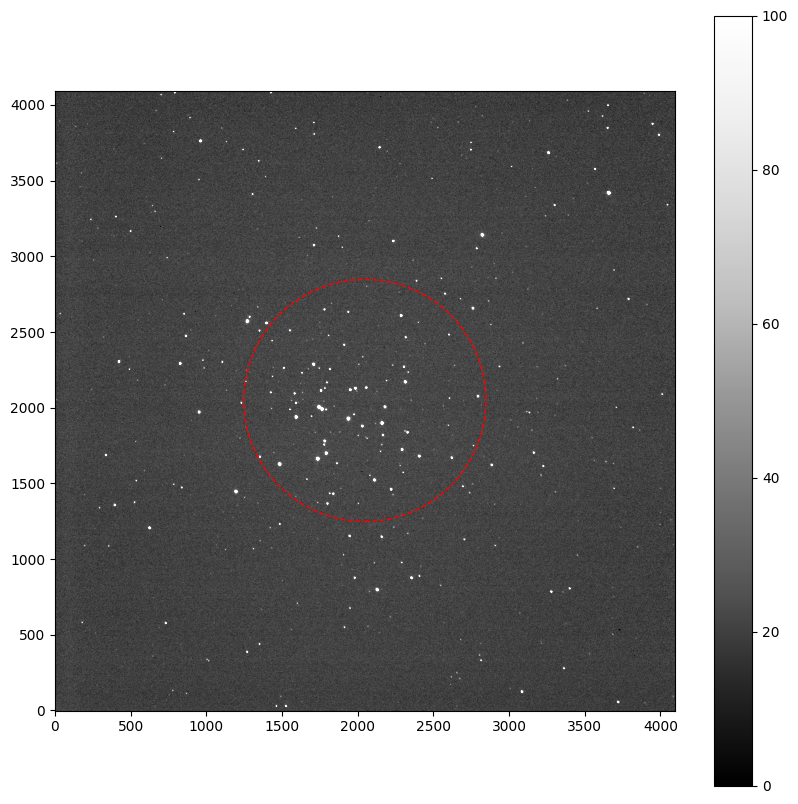

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(corr_arr, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 100)


center_of_frame = (int(corr_arr.shape[0]/2), int(corr_arr.shape[1]/2))  # This is the center, where the open cluster should be
radius = 800   # The observed radius of the open cluster, this has to be set manually

# We performed the photometry for the whole frame, but most likely some of the stars are not cluster members. The easiest way to
# remove these from the sample is to apply a constrain on the observed distance from the cluster; or to include only the stars
# that fall into the circle we draw.

circle1 = plt.Circle(center_of_frame, radius, color = 'None', ec = 'red', ls = '--')
ax.add_patch(circle1)
plt.colorbar()

In [25]:
# Condition to tell, whether the stars are in the circle plotted above or not
pos_cond = np.sqrt(np.square(df['X_c'] -  center_of_frame[0]) + np.square(df['Y_c'] -  center_of_frame[1])) < radius

### After applying the condition we can replot the CMDs to see the effects

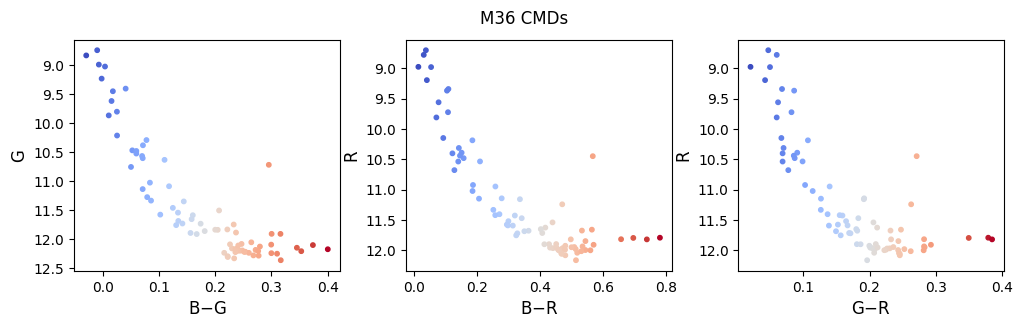

In [26]:
f = plt.figure(figsize = (12,3))
f.subplots_adjust(wspace = 0.25)

plt.suptitle('M36 CMDs', fontsize = 12)

ax = f.add_subplot(1,3,1)
plot_CMD('B', 'G', df[pos_cond])

ax = f.add_subplot(1,3,2)
plot_CMD('B', 'R', df[pos_cond])

ax = f.add_subplot(1,3,3)
plot_CMD('G', 'R', df[pos_cond])

And indeed, most of the outlier objects were succesfully removed, leaving us with the main sequence of the open cluster clearly visible.

## And this is it basically, this is what we wanted to achieve